In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import chi2, mutual_info_classif, f_regression, f_classif

### Loading the modified dataset

In [9]:
df = pd.read_csv('dataset/data_merged.csv')
list(df.columns)
del df['mode']
del df['key_6_yr']
# del df['popularity_yr']
# del df['popularity_ar']

In [10]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,speechiness_yr,tempo_yr,valence_yr,popularity_yr,key_0_yr,key_1_yr,key_2_yr,key_3_yr,key_4_yr,key_5_yr
0,0.0131,0.2560,182347,0.895,0,0.000106,0.0821,-4.860,29,0.0707,...,0.064961,120.209319,0.583424,35.272231,0,0,1,0,0,0
1,0.9800,0.2770,206972,0.145,0,0.879000,0.1110,-19.898,0,0.0845,...,0.092591,110.008113,0.432251,3.672500,1,0,0,0,0,0
2,0.7950,0.6850,314667,0.483,0,0.878000,0.1130,-10.202,1,0.0337,...,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
3,0.6560,0.7880,179747,0.808,0,0.000000,0.1540,-6.590,0,0.0395,...,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
4,0.3020,0.0753,498560,0.150,0,0.884000,0.1210,-16.705,0,0.0371,...,0.107351,109.569882,0.443625,3.419500,1,0,0,0,0,0


### Linear Regression

In [11]:
X = df[df.columns.difference(['popularity'])]
y = df['popularity']
X_new = SelectKBest(f_regression, k=25).fit_transform(X, y)
X_new.shape

(172230, 25)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, stratify=y)
clf = LinearRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### Polynomial Regression

In [8]:
poly = PolynomialFeatures(degree=2) ## Degree 3 kills my PC! I think the issue is not enough RAM. 
X_poly = poly.fit_transform(X_new)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_poly, y, test_size=0.2)
clf1 = LinearRegression().fit(X_train1, y_train1)
y_pred1 = clf1.predict(X_test1)
print('Coefficient of determination: %.2f'
      % r2_score(y_test1, y_pred1))
print('Mean squared error: %.2f'
      % mean_squared_error(y_test1, y_pred1))

KeyboardInterrupt: 

With all features polynomial regression for degree = 2 gives an r2_score of 0.64

###  Logistic Regression

#### With 3 categories

In [13]:
X1 = df[df.columns.difference(['popularity'])]
y1 = pd.cut(x=df["popularity"], bins=[-1,20,50,100], labels=[0,1,2]) ## Threshold can be either 50 (median) or 26 (mean)
X_new1 = SelectKBest(f_classif, k=27).fit_transform(X1, y1)
X_new1.shape

(172230, 27)

Here, a maximum accuracy score of 0.641 is achieved upon selecting 27 features, after which the score more or less plateaus and the optimization function fails to converge within a small number of iterations. 

Increasing the max number of iterations allows it to converge but the accuracy score does not see any improvement. 

In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new1, y1, test_size=0.20, stratify=y1)
clf2 = LogisticRegression(random_state=42).fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
accuracy_score(y_test2, y_pred2)

/home/prayag_s/dev/Academic/ml-spotify/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8035185507751262

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     14752
           1       0.70      0.89      0.78     14319
           2       0.94      0.16      0.27      5375

    accuracy                           0.79     34446
   macro avg       0.85      0.66      0.66     34446
weighted avg       0.82      0.79      0.76     34446



Why does the accuracy score give different values everytime I run it? I have fixed the random_state. 

#### With 2 categories

In [18]:
y1 = pd.cut(x=df["popularity"], bins=[-1,50,100], labels=[0,1]) ## Threshold can be either 50 (median) or 26 (mean)
X_new1 = SelectKBest(f_classif, k=27).fit_transform(X1, y1)

mean_popularity = 50
df["popularity"] = [ 1 if i >= mean_popularity else 0 for i in df.popularity ]
y1 = df["popularity"].values
# Counter(y1)

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new1, y1, test_size=0.2, random_state=42, stratify=y1)
clf2 = LogisticRegression(random_state=42).fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
accuracy_score(y_test2, y_pred2)

0.9110782093711897

In [20]:
accuracy_score(y_train2, clf2.predict(X_train2))

0.9105629100621262

In [21]:
print(classification_report(y_test2, y_pred2))

NameError: name 'classification_report' is not defined

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
# predict probabilities
lr_probs = clf2.predict_proba(X_test2)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test2, lr_probs)
lr_auc

0.9299054667776778

Best Threshold=0.193880, G-Mean=0.843


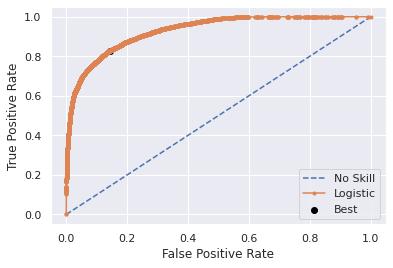

In [98]:
from matplotlib import pyplot
from numpy import sqrt, argmax, save
import numpy as np
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test2, lr_probs)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

SVM: f1=0.705 auc=0.792
Best Threshold=0.417149, F-Score=0.712


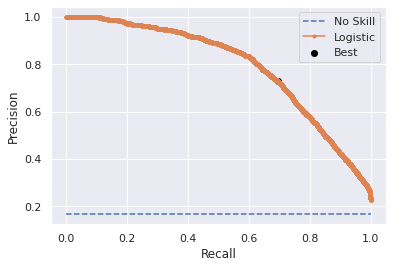

In [99]:
from sklearn.metrics import auc, precision_recall_curve, f1_score
lr_precision, lr_recall, thresholds = precision_recall_curve(y_test2, lr_probs)
lr_f1, lr_auc = f1_score(y_test2, y_pred2), auc(lr_recall, lr_precision)
# summarize scores
print('SVM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# convert to f score
fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
# locate the index of the largest f 
from numpy import argmax
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
pyplot.scatter(lr_recall[ix], lr_precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [100]:
import numpy as np
f = open("fpr_lr", "wb")
f1 = open("tpr_lr", "wb")
f2 = open("lr_pre_lr", "wb")
f3 = open("lr_rec_lr", "wb")
np.save(f, fpr)
np.save(f1, tpr)
np.save(f2, lr_precision)
np.save(f3, lr_recall)

Convergence sometimes happens, sometimes not. 

### Reducing Sample Size

In [12]:
from sklearn.utils import resample

In [26]:
df_cut = resample(df, n_samples=10000, replace = False)
#X_cut=pd.DataFrame(X_cut, columns = X_new.columns.tolist())
df_cut.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,...,loudness_yr,speechiness_yr,tempo_yr,valence_yr,key_0_yr,key_1_yr,key_2_yr,key_3_yr,key_4_yr,key_5_yr
7283,0.000146,0.475,234867,0.439,0,0.000277,0.2230,-15.039,69,0.0427,...,-11.849538,0.074276,118.993133,0.582433,0,0,1,0,0,0
51924,0.013100,0.466,276973,0.763,0,0.028200,0.0929,-7.205,28,0.0299,...,-9.230797,0.082572,120.878793,0.433697,0,0,0,0,1,0
138867,0.895000,0.401,178893,0.248,0,0.000126,0.1300,-10.213,31,0.0302,...,-11.789685,0.053659,119.346342,0.593672,0,0,1,0,0,0
156962,0.995000,0.599,173987,0.136,0,0.890000,0.1140,-21.655,0,0.0644,...,-15.235276,0.261915,112.663707,0.669676,0,1,0,0,0,0
35047,0.396000,0.625,187333,0.578,0,0.000540,0.0320,-12.472,50,0.0315,...,-10.714379,0.058307,122.672871,0.595666,1,0,0,0,0,0


In [27]:
X2 = df_cut[df_cut.columns.difference(['popularity'])]
y2 = df_cut['popularity']
X_new2 = SelectKBest(f_regression, k=25).fit_transform(X2, y2)
X_new2.shape

(10000, 25)

In [29]:
poly = PolynomialFeatures(degree=3) ## Degree 3 kills my PC! I think the issue is not enough RAM. 
X_poly = poly.fit_transform(X_new)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_poly, y, test_size=0.2)
clf1 = LinearRegression().fit(X_train1, y_train1)
y_pred1 = clf1.predict(X_test1)
print('Coefficient of determination: %.2f'
      % r2_score(y_test1, y_pred1))
print('Mean squared error: %.2f'
      % mean_squared_error(y_test1, y_pred1))

Coefficient of determination: 0.64
Mean squared error: 170.50


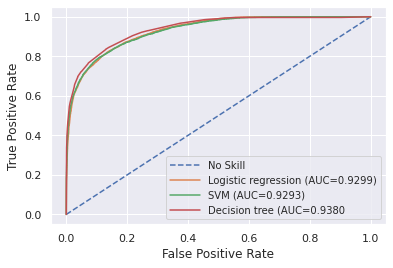

34446 0.16646345003774024


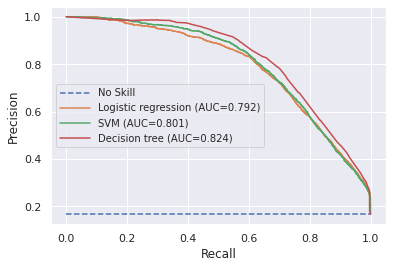

In [25]:
from matplotlib import pyplot
d = open("fpr_dtr", "rb")
d1 = open("tpr_dtr", "rb")
d2 = open("lr_pre_dtr", "rb")
d3 = open("lr_rec_dtr", "rb")
l = open("fpr_lr", "rb")
l1 = open("tpr_lr", "rb")
l2 = open("lr_pre_lr", "rb")
l3 = open("lr_rec_lr", "rb")
s = open("fpr_svm", "rb")
s1 = open("tpr_svm", "rb")
s2 = open("lr_pre_svm", "rb")
s3 = open("lr_rec_svm", "rb")

params = {'legend.fontsize': 10,
          'legend.handlelength': 3}
pyplot.rcParams.update(params)


pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(np.load(l), np.load(l1), label='Logistic regression (AUC=0.9299)')
pyplot.plot(np.load(s), np.load(s1), label='SVM (AUC=0.9293)')
pyplot.plot(np.load(d), np.load(d1), label='Decision tree (AUC=0.9380')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot

pyplot.savefig("ROC_OG.png")
pyplot.show()

no_skill = len(y_test2[y_test2==1]) / len(y_test2)
print(len(y_test2), no_skill)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(np.load(l3), np.load(l2), label='Logistic regression (AUC=0.792)')
pyplot.plot(np.load(s3), np.load(s2), label='SVM (AUC=0.801)')
pyplot.plot(np.load(d3), np.load(d2), label='Decision tree (AUC=0.824)')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot

pyplot.savefig("PVR_OG.png")
pyplot.show()